(bell)=
# Tutorial on the nobel prize 2022 - How to win Bell's game

The nobel prize of physics for the year 2022 was awarded to three physicists for the test of Bell inequalities. As this work is foundational to any kind of modern quantum technology, we decided to provide you here with a description of the experiments in terms of a game. While the game is slightly odd it shows you nicely how quantum mechanics allow you to break the casino and what the experiments demonstrated specifically. 

To make the discussion very direct and hands-on we will implement it in some simple `qiskit` circuits such that you can test them directly on your own. 

In [1]:
import random

from qiskit.circuit import QuantumCircuit
from qiskit import Aer

import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange

## The casino version of Bell's (CHSH) game

A casino invented a new and exciting game, where Alice and Bob can try to win some nice objects at a huge discount  together. To participate in the game they have to pay 300 € as a team, but they have a good chance to come out of the game with objects that are worth 400€. Here are the rules of the game:

- Alice and Bob have to go into isolated cabins, where they get to see one out of two nice Apple watches (one being black and one being white). Quite importantly, they do not know which car was given to the other contestant.
- Now Alice and Bob have to tell the Referee what they would like to do. They have two options. They can either say that they would like to "sell" the watch or "keep" it. 

After they told the referee, their answers are compared. They can win in the following fashion:

- If Alice and Bob both saw a white watch, they win of one wanted to "sell" and the other one wanted to "keep" the car.
- In any other case, they win if both answered the same way ("keep" or "sell")

Let us simply translate these rules into python code.




In [2]:
def bell_game(color_a: str, color_b: str, choice_a: str, choice_b: str) -> str:
    """
    The bell casino game translated into python

    Args:
      color_a: the color that Alice sees (either `black` or `white`)
      color_b: the color that Alice sees (either `black` or `white`)
      choice_a: the choice the Alice makes (`keep` or `sell`)
      choice_b: the choice the Bob makes (`keep` or `sell`)

    Returns:
      A sring that says if Alice and Bob "won" or "lost"
    """
    # the one case where Alice and Bob have to have different results
    if color_a == "white" and color_b == "white":
        if choice_a == "keep" and choice_b == "sell":
            return "won"
        if choice_a == "sell" and choice_b == "keep":
            return "won"
    else:
        if choice_a == choice_b:
            return "won"
    return "lost"

## The best classical strategy
It turns out that the best way to win for Alice and Bob is to cooperate and decide before if they would like to "keep" or "sell" the watch. Then they will get their wish in 75% of the cases and only lose if both see a white watch. We can even simulate this casino session in simple python code

In [3]:
n_games = 10000
wins = np.zeros(n_games)

# Alice and Bob decided to cooperate and always say "sell"
choice_alice = "sell"
choice_bob = "sell"

for ii in range(n_games):

    # get the colors
    color_alice = random.choice(["black", "white"])
    color_bob = random.choice(["black", "white"])

    result = bell_game(color_alice, color_bob, choice_alice, choice_bob)
    if result == "won":
        wins[ii] = 1

print(
    "Alice and Bob won {} games out of {}. Hence a win rate of {:.2f} %".format(
        wins.sum(), n_games, wins.sum() / n_games * 100
    )
)

Alice and Bob won 7489.0 games out of 10000. Hence a win rate of 74.89 %


We can see this makes the game fair as Bob and Alice have an expectation value of exactly 300€, so the casino and the players will have just an enjoyable time if we look at the wins and losses over the games. 

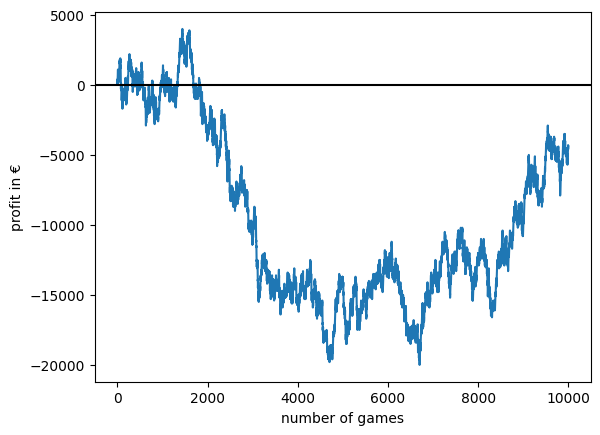

In [4]:
profit = wins * 400 - np.ones(n_games) * 300
accu_profit = profit.cumsum()

f, ax = plt.subplots()
ax.plot(accu_profit)
ax.set_ylabel("profit in €")
ax.set_xlabel("number of games")
ax.axhline(0, color="k")

## Breaking the casino with quantum technologies

Quite interestingly Alice and Bob could win more often if they have access to quantum technologies. So we just assume that Alice and Bob are really good techies and had access to a quantum computer, which allows them to entangle two qubits. Let us first plot up the kind of instructions that Alice and Bob have to give the quantum computer to obtain the entangled pair.

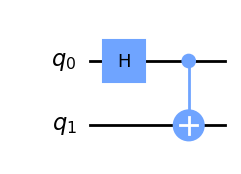

In [5]:
sim = Aer.get_backend("aer_simulator")

qc = QuantumCircuit(2)
qc.h(0)
qc.cx(0, 1)
qc.draw("mpl")

As a result of the circuit they have created a pair of entangled qubits. Imagine now that Alice and Bob can each one take one of the qubits into their cabin to play the quantum game. Given that Alice and Bob have to carry the qubit they have to have it in a box with two buttons. 

- The first button says `measurement` such that they can read out the recommendation of their qubit. 
- The second button allows them change their personal qubit a bit once they saw if they have a white or black watch in front of them.
- The key thing is that the box is not sending out any signal to the other player. So they are following perfectly the rules of the casino.

## A naive quantum strategy

A naive way of using the qubit is to simply push the `measurement` and nothing else.If the qubit results in a zero, they will tell the casino that they would like to "keep" the watch. If it is qubit result is a one, they decide to "sell" the watch. 

We can just implement this once as a `qiskit` circuit and look at the result.

In [6]:
n_games = 10000

naive_q_wins = np.zeros(n_games)
for ii in trange(n_games):

    color_alice = random.choice(["black", "white"])
    color_bob = random.choice(["black", "white"])

    # time to prepare the Bell pair
    qc = QuantumCircuit(2)
    qc.h(0)
    qc.cx(0, 1)

    # both measure
    qc.measure_all()

    # now run the circuit
    job = sim.run(qc, shots=1)
    outcome = job.result().get_counts()

    # a horribly intransparent way to get the value of the outcome
    keys = [*outcome][0]
    choice_alice = "sell" if keys[0] == "0" else "keep"
    choice_bob = "sell" if keys[1] == "0" else "keep"

    result = bell_game(color_alice, color_bob, choice_alice, choice_bob)
    if result == "won":
        naive_q_wins[ii] = 1

print("")
print(
    "Alice and Bob won {} games out of {}. Hence a win rate of {:.2f} %".format(
        naive_q_wins.sum(), n_games, naive_q_wins.sum() / n_games * 100
    )
)

100%|███████████████████████████████████| 10000/10000 [00:03<00:00, 2953.99it/s]


Alice and Bob won 7500.0 games out of 10000. Hence a win rate of 75.00 %


As you can see above the players right now will always make the same choice. This is just a very geeky variation of the classical strategy that we implemented above. 




## The winning quantum strategy

But being really good in quantum tech, Alice and Bob now also have the second button  at hand to have a more sophisticated strategy, which allows them to take into account the color of the watches that they see in front of them. 

So what is the physics Bob and Alice developped the following strategy:

- If Alice sees a *black* watch she simply measures her qubit.
- If Alice sees a *white* watch she changes her personal qubit a bit by pushing the button on her qubit bag. In physics terms, it applies a hardamard gate on her qubit. Then she measures her qubit.


Bob does the following:

- If he sees a *white* watch he switches the button to `white`. This performs $R_y$ a rotation of qubit by $\frac{\pi}{8}$. 
- If he sees a *black* watch he switches the button to `black`. This performs $R_y$ a rotation of qubit by $-\frac{\pi}{8}$. 

In [7]:
n_games = 10000

fancy_q_wins = np.zeros(n_games)
for ii in trange(n_games):

    # get the numbers that tell us if Alice and Bob obtained
    # a white or a black watch
    color_alice = random.choice(["black", "white"])
    color_bob = random.choice(["black", "white"])

    # time to prepare the Bell pair
    qc = QuantumCircuit(2)
    qc.h(0)
    qc.cx(0, 1)

    # Alice acts her qubit
    if color_alice == "white":
        qc.h(0)

    # Bob acts on his qubit
    if color_bob == "white":
        qc.ry(np.pi / 8, 1)
    else:
        qc.ry(-np.pi / 8, 1)

    # both measure
    qc.measure_all()

    # now run the circuit
    job = sim.run(qc, shots=1)
    outcome = job.result().get_counts()
    result = "lost"

    # a horribly intransparent way to get the value of the outcome
    keys = [*outcome][0]
    choice_alice = "sell" if keys[0] == "0" else "keep"
    choice_bob = "sell" if keys[1] == "0" else "keep"

    result = bell_game(color_alice, color_bob, choice_alice, choice_bob)
    if result == "won":
        fancy_q_wins[ii] = 1

print("")
print(
    "Alice and Bob won {} games out of {}. Hence a win rate of {:.2f} %".format(
        fancy_q_wins.sum(), n_games, fancy_q_wins.sum() / n_games * 100
    )
)

100%|███████████████████████████████████| 10000/10000 [00:03<00:00, 2636.13it/s]


Alice and Bob won 8318.0 games out of 10000. Hence a win rate of 83.18 %


(0.0, 10000.0)

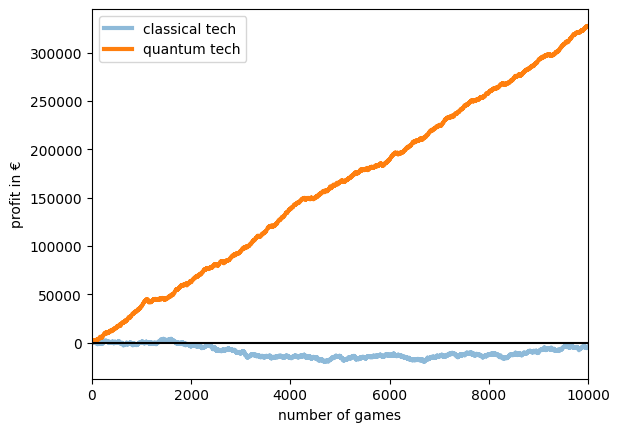

In [8]:
fancy_profit = fancy_q_wins * 400 - np.ones(n_games) * 300
fancy_accu_profit = fancy_profit.cumsum()

f, ax = plt.subplots()
ax.plot(accu_profit, label="classical tech", lw=3, alpha=0.5)
ax.plot(fancy_accu_profit, label="quantum tech", lw=3)
ax.axhline(0, color="k")
ax.set_ylabel("profit in €")
ax.set_xlabel("number of games")
ax.legend()
ax.set_xlim(0, n_games)

This graph nicely summarizes that Alice and Bob have found a clear **quantum advantage** in the game. They could break the casino if the casino let's them play long enough. It is fairly crucial to underline that Alice and Bob did not cheat in any way. They were simply able to do **more** with quantum technologies than it would be possible with any classical approach.

## The link to the Nobel prize

This quantum advantage was formulated in a clean fashion in Bell's inequalities in the 1970s. The three Nobel prize winners (John Clauser, Alain Aspect, Anton Zeilinger) tested experimentally that it is indeed possible for Alice and Bob to break the casino without any cheating. 

Of course, the experimentalists did not take qubits into a casino. The experiments performed the game in highly controlled lab experiments. The qubits were implemented through flying photons and the decisions on the colors of the watches were high quality random number generators. Even as the experiments became more and more sophisticated they continued to show that the entangled qubits allowed for quantum advantage. And this work was so foundational to modern quantum technologies that it obtained this years [Nobel prize](https://www.nobelprize.org/prizes/physics/2022/press-release/). Modern quantum computing systems and sophisticated algorithms essentially attempts to reproduce this clear advantage in increasingly complex situations like [unsupervised machine learning](https://alqor.io/tutorials/introduction-to-generative-modelling-with-quantum-hardware).
